# Exploratory Data Analysis

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [2]:
import sys

sys.path.append("..")
from utils import load_mocov_train_data, load_mocov_test_data

In [3]:
# data path
data_path = Path("../storage")

## Output Data

In [4]:
output = pd.read_csv(os.path.join(data_path, "train_output.csv"))

In [5]:
# check the distribution of the target
output.describe()

,Target
count,344.000000
mean,0.372093
std,0.484067
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


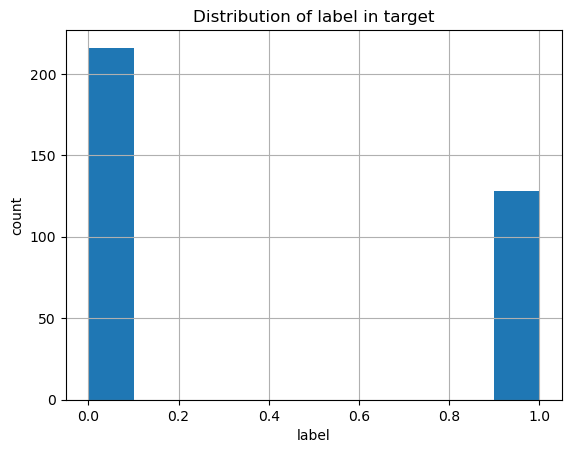

In [6]:
output.hist()
plt.title("Distribution of label in target")
plt.xlabel("label")
plt.ylabel("count");

## Metadata

In [7]:
md_train = pd.read_csv(
    os.path.join(data_path, "supplementary_data", "train_metadata.csv")
)
md_test = pd.read_csv(
    os.path.join(data_path, "supplementary_data", "test_metadata.csv")
)

First, we analyse the training metadata.

In [8]:
md_train.describe()

,Sample ID,Patient ID,Center ID
count,344,344,344
unique,344,305,3
top,ID_001.npy,P_127,C_1
freq,1,3,138


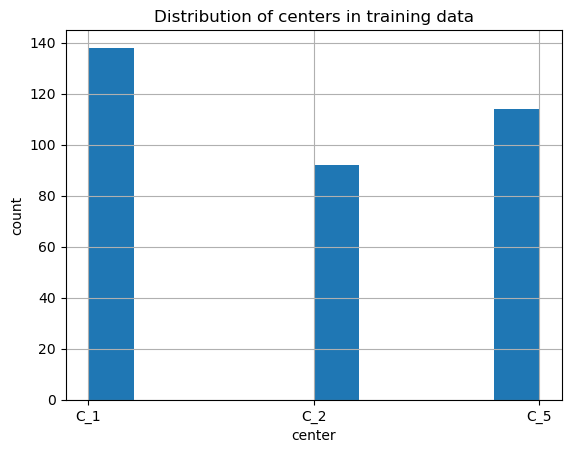

In [9]:
# check the distribution of different centers in data
md_train["Center ID"].hist()
plt.title("Distribution of centers in training data")
plt.xlabel("center")
plt.ylabel("count");

In [10]:
output_md = md_train.merge(output, on="Sample ID")

In [11]:
# check the target distribution per center
output_md.loc[:, ["Center ID", "Target"]].groupby(by="Center ID").value_counts(
    normalize=True
)

Center ID  Target
C_1        0         0.644928
           1         0.355072
C_2        0         0.641304
           1         0.358696
C_5        0         0.596491
           1         0.403509
dtype: float64

We are going to look closer at the duplicate patient IDs in the training data.

In [12]:
# get patient ids where we have multiple samples
patient_dups = md_train[md_train.duplicated(subset=["Patient ID"])]

In [13]:
# check the centers where mulitple samples per patient appear
patient_dups["Center ID"].unique()

array(['C_5'], dtype=object)

In [14]:
# check how many patients have multiple samples
len(patient_dups["Center ID"])

39

In [15]:
# analyse the number of samples per patient
output_md.loc[
    output_md["Patient ID"].isin(patient_dups["Patient ID"]), "Patient ID"
].value_counts().head()

P_127    3
P_239    2
P_162    2
P_163    2
P_165    2
Name: Patient ID, dtype: int64

In [16]:
# analyse for which targets the multiple samples happen
output_md.loc[
    output_md["Patient ID"].isin(patient_dups["Patient ID"])
].Target.value_counts()

0    46
1    31
Name: Target, dtype: int64

/var/folders/y_/2nw1qxt94ydbkmv5qzg8p4080000gn/T/ipykernel_61684/429582591.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  output_md.loc[output_md["Patient ID"].isin(patient_dups["Patient ID"])]


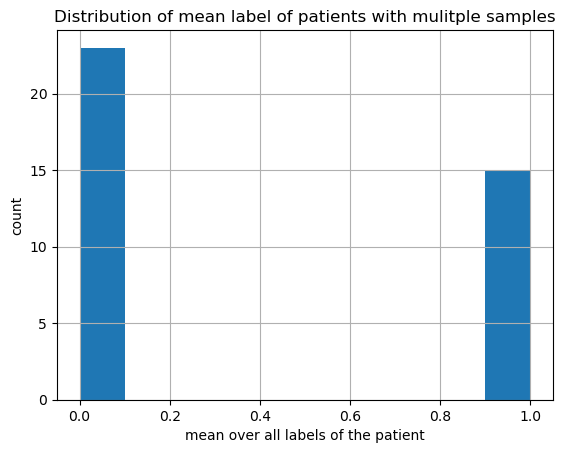

In [17]:
# check if the sample targerts for one patient are the same or change
shares_dups = (
    output_md.loc[output_md["Patient ID"].isin(patient_dups["Patient ID"])]
    .groupby(by="Patient ID")
    .mean()
)
shares_dups.hist()
plt.title("Distribution of mean label of patients with mulitple samples")
plt.xlabel("mean over all labels of the patient")
plt.ylabel("count");

In [18]:
# check the target distribution per center without duplicates
output_md.drop_duplicates(subset=["Patient ID"]).loc[
    :, ["Center ID", "Target"]
].groupby(by="Center ID").value_counts(normalize=True)

Center ID  Target
C_1        0         0.644928
           1         0.355072
C_2        0         0.641304
           1         0.358696
C_5        0         0.600000
           1         0.400000
dtype: float64

In the following we are going to do the same analysis for the test metadata.

In [19]:
md_test.describe()

,Sample ID,Patient ID,Center ID
count,149,149,149
unique,149,149,2
top,ID_003.npy,P_003,C_3
freq,1,1,76


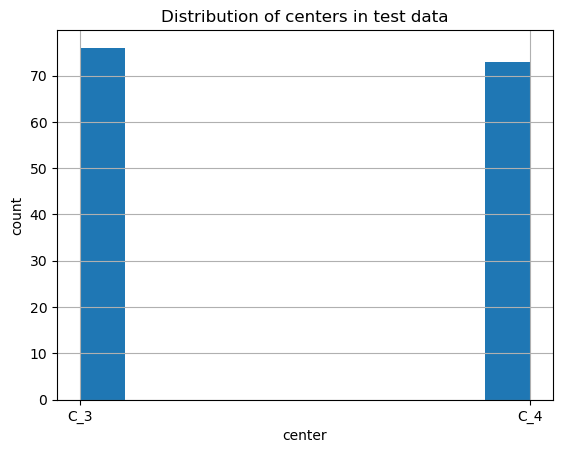

In [20]:
md_test["Center ID"].hist()
plt.title("Distribution of centers in test data")
plt.xlabel("center")
plt.ylabel("count");

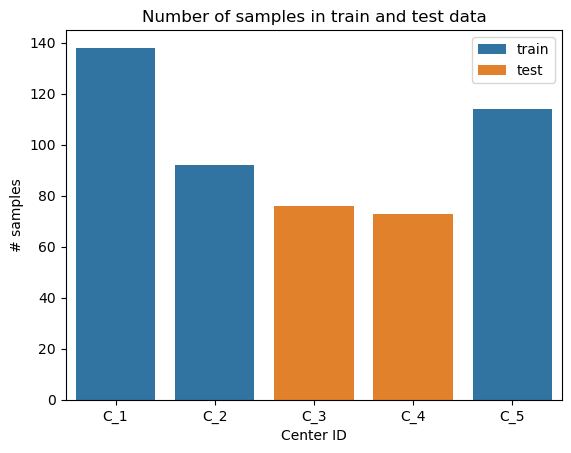

In [21]:
plot_df = pd.concat([output_md, md_test])[["Center ID"]]
plot_df = pd.DataFrame(
    {
        "count": plot_df.value_counts().sort_index(),
        "data": ["train", "train", "test", "test", "train"],
    }
).reset_index()
sns.barplot(data=plot_df, x="Center ID", y="count", hue="data", dodge=False)
plt.title("Number of samples in train and test data")
plt.ylabel("# samples")
plt.gca().legend().set_title("")
# plt.savefig('../images/Report/samples_per_center.pdf', bbox_inches='tight');

Interesting to see is that center 1,2,5 are used for the training sample and center 3,4 are used for the test sample.

**Assumption:** Center 3 is used for the public test data and center 4 is used for the private test data.

## MoCov features

In [22]:
train_features_dir = data_path / "train_input" / "moco_features"

X_train = []
y_train = []
centers_train = []
patients_train = []
zoom_levels = []

for sample, label, center, patient in tqdm(
    output_md[["Sample ID", "Target", "Center ID", "Patient ID"]].values
):
    # load the coordinates and features (1000, 3+2048)
    _features = np.load(train_features_dir / sample)
    # get coordinates (zoom level, tile x-coord on the slide, tile y-coord on the slide)
    # and the MoCo V2 features
    coordinates, features = _features[:, :3], _features[:, 3:]  # Ks
    # slide-level averaging
    X_train.append(np.mean(features, axis=0))
    y_train.append(label)
    centers_train.append(center)
    patients_train.append(patient)
    zoom_levels.append(coordinates[:, 0])

# convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
centers_train = np.array(centers_train)
patients_train = np.array(patients_train)

100%|██████████| 344/344 [00:01<00:00, 205.90it/s]


In [23]:
mut = X_train[y_train == 1, :]
nomut = X_train[y_train == 0, :]

In [24]:
mut_mean = np.mean(mut, axis=1)
nomut_mean = np.mean(nomut, axis=1)

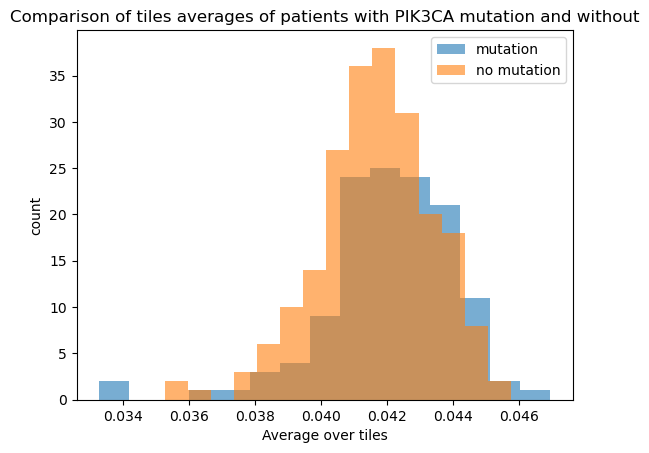

In [25]:
plt.hist(mut_mean, bins=15, label="mutation", alpha=0.6)
plt.hist(nomut_mean, bins=15, label="no mutation", alpha=0.6)
plt.legend()
plt.title("Comparison of tiles averages of patients with PIK3CA mutation and without")
plt.ylabel("count")
plt.xlabel("Average over tiles");

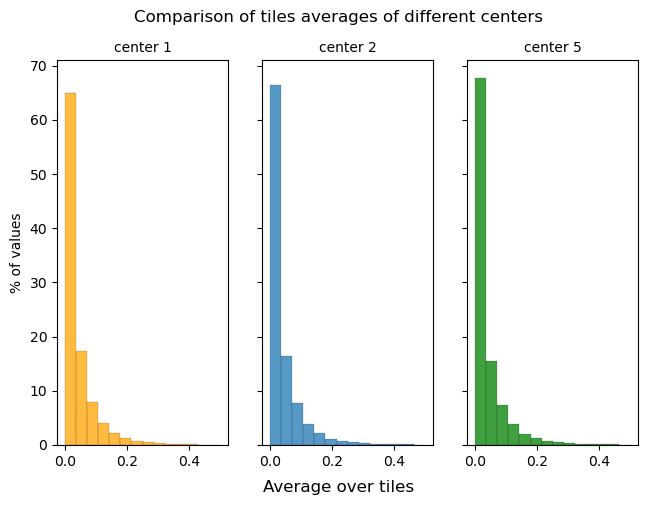

In [26]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(7.5, 5))
bins = np.linspace(0, 0.5, 15)
sns.histplot(
    X_train[centers_train == "C_1"].flatten(),
    ax=axs[0],
    bins=bins,
    stat="percent",
    color="orange",
    linewidth=0.1,
)
sns.histplot(
    X_train[centers_train == "C_2"].flatten(),
    ax=axs[1],
    bins=bins,
    stat="percent",
    linewidth=0.1,
)
sns.histplot(
    X_train[centers_train == "C_5"].flatten(),
    ax=axs[2],
    bins=bins,
    stat="percent",
    color="green",
    linewidth=0.1,
)
axs[0].set_title("center 1", size=10)
axs[1].set_title("center 2", size=10)
axs[2].set_title("center 5", size=10)
fig.suptitle("Comparison of tiles averages of different centers")
fig.supxlabel("Average over tiles")
axs[0].set_ylabel("% of values");

### Analysing zoom levels

In [27]:
np.unique(zoom_levels)

array([15., 16., 17.], dtype=float32)

In [28]:
zoom = np.empty(0)
for i in range(344):
    if len(np.unique(zoom_levels[i])) > 1:
        print("More than one zoom level for one sample")
    zoom = np.hstack((zoom, np.unique(zoom_levels[i])))

In [29]:
zoom_train = md_train.copy()
zoom_train["zoom"] = zoom

In [30]:
zoom_train.groupby("Center ID")["zoom"].agg(["unique"])

,unique
Center ID,
C_1,"[17.0, 16.0, 15.0]"
C_2,"[16.0, 17.0]"
C_5,"[16.0, 17.0, 15.0]"


In [31]:
zoom_train.groupby("Center ID")["zoom"].value_counts()

Center ID  zoom
C_1        16.0    110
           17.0     25
           15.0      3
C_2        16.0     71
           17.0     21
C_5        16.0     96
           17.0     16
           15.0      2
Name: zoom, dtype: int64

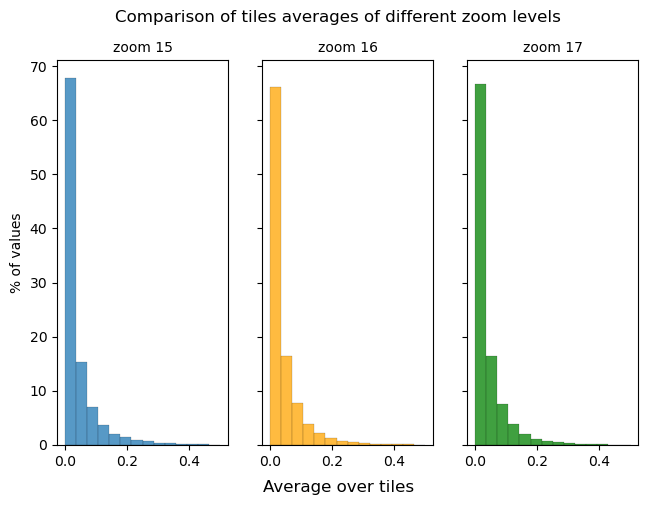

In [32]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(7.5, 5))
bins = np.linspace(0, 0.5, 15)
sns.histplot(
    ax=axs[0],
    x=X_train[zoom == 15.0].flatten(),
    stat="percent",
    bins=bins,
    linewidth=0.1,
)
sns.histplot(
    ax=axs[1],
    x=X_train[zoom == 16.0].flatten(),
    stat="percent",
    color="orange",
    bins=bins,
    linewidth=0.1,
)
sns.histplot(
    ax=axs[2],
    x=X_train[zoom == 17.0].flatten(),
    stat="percent",
    color="green",
    bins=bins,
    linewidth=0.1,
)
axs[0].set_title("zoom 15", size=10)
axs[1].set_title("zoom 16", size=10)
axs[2].set_title("zoom 17", size=10)
fig.suptitle("Comparison of tiles averages of different zoom levels")
fig.supxlabel("Average over tiles")
axs[0].set_ylabel("% of values");

In [33]:
zoom_train.loc[zoom_train["Patient ID"].isin(patient_dups["Patient ID"]), :].groupby(
    "Patient ID"
)["zoom"].agg(["unique"])

,unique
Patient ID,
P_005,"[16.0, 17.0]"
P_014,"[17.0, 16.0]"
P_020,[16.0]
P_025,[16.0]
P_028,"[17.0, 16.0]"
P_050,"[16.0, 17.0]"
P_052,"[17.0, 16.0]"
P_055,[16.0]
P_057,[16.0]


In [34]:
zoom_train.loc[zoom_train["Patient ID"] == "P_127"]

,Sample ID,Patient ID,Center ID,zoom
97,ID_132.npy,P_127,C_5,15.0
143,ID_203.npy,P_127,C_5,16.0
161,ID_233.npy,P_127,C_5,16.0


Looking at the test moco features and their zoom level:

In [35]:
test_features_dir = data_path / "test_input" / "moco_features"

X_test = []
centers_test = []
patients_test = []
zoom_test = []

for sample, center, patient in tqdm(
    md_test[["Sample ID", "Center ID", "Patient ID"]].values
):
    # load the coordinates and features (1000, 3+2048)
    _features = np.load(test_features_dir / sample)
    # get coordinates (zoom level, tile x-coord on the slide, tile y-coord on the slide)
    # and the MoCo V2 features
    coord_test, features_test = _features[:, :3], _features[:, 3:]  # Ks
    # slide-level averaging
    X_test.append(np.mean(features_test, axis=0))
    centers_test.append(center)
    patients_test.append(patient)
    zoom_test.append(coord_test[:, 0])

# convert to numpy arrays
X_test = np.array(X_test)
centers_test = np.array(centers_test)
patients_test = np.array(patients_test)

100%|██████████| 149/149 [00:00<00:00, 225.76it/s]


In [36]:
np.unique(zoom_test)

array([14., 15., 16., 17.], dtype=float32)

In [37]:
zoom = np.empty(0)
for i in range(149):
    if len(np.unique(zoom_test[i])) > 1:
        print("More than one zoom level for one sample")
    zoom = np.hstack((zoom, np.unique(zoom_test[i])))

In [38]:
zoom_df = md_test.copy()
zoom_df["zoom"] = zoom

In [39]:
zoom_df.groupby("Center ID")["zoom"].agg(["unique"])

,unique
Center ID,
C_3,"[16.0, 17.0]"
C_4,"[14.0, 16.0, 15.0]"


In [40]:
zoom_df.groupby("Center ID")["zoom"].value_counts()

Center ID  zoom
C_3        16.0    72
           17.0     4
C_4        15.0    42
           16.0    29
           14.0     2
Name: zoom, dtype: int64

In [41]:
plot_df = pd.DataFrame(
    pd.concat([zoom_train, zoom_df]).groupby("Center ID")["zoom"].value_counts()
)
plot_df.columns = ["count"]
plot_df.reset_index(inplace=True)

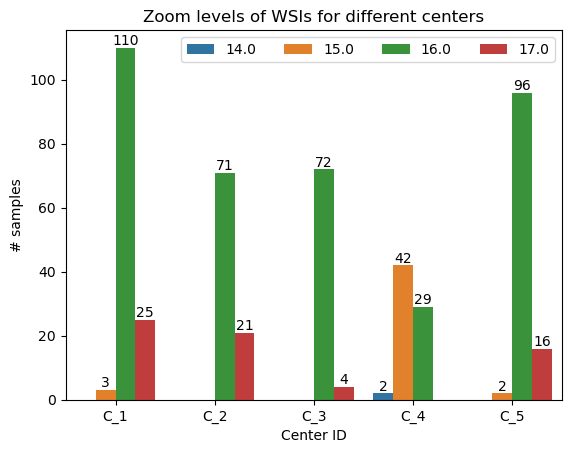

In [42]:
ax = sns.barplot(data=plot_df, x="Center ID", y="count", hue="zoom")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Zoom levels of WSIs for different centers")
plt.ylabel("# samples")
plt.gca().legend(loc="upper right", ncol=4).set_title("")
# plt.savefig('../images/Report/zoomlevels_per_center.pdf', bbox_inches='tight');

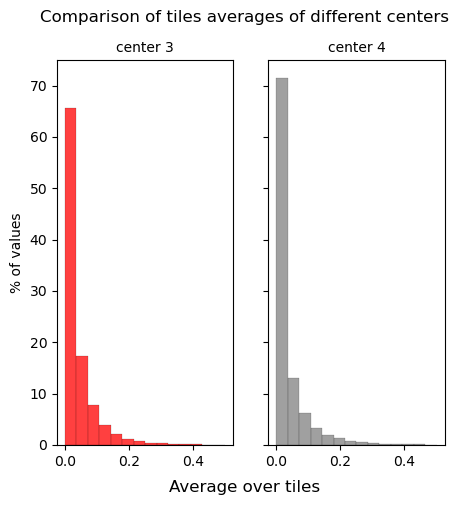

In [43]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(5, 5))
bins = np.linspace(0, 0.5, 15)
sns.histplot(
    ax=axs[0],
    data=X_test[centers_test == "C_3"].flatten(),
    stat="percent",
    color="red",
    bins=bins,
    linewidth=0.1,
)
sns.histplot(
    ax=axs[1],
    data=X_test[centers_test == "C_4"].flatten(),
    stat="percent",
    color="grey",
    bins=bins,
    linewidth=0.1,
)
axs[0].set_title("center 3", size=10)
axs[1].set_title("center 4", size=10)
fig.suptitle("Comparison of tiles averages of different centers")
fig.supxlabel("Average over tiles")
axs[0].set_ylabel("% of values");

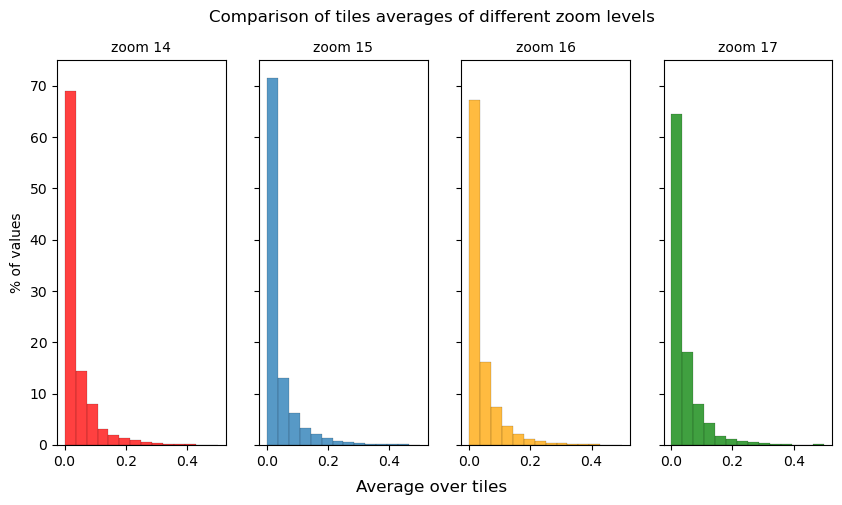

In [44]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(10, 5))
bins = np.linspace(0, 0.5, 15)
sns.histplot(
    ax=axs[0],
    x=X_test[zoom == 14.0].flatten(),
    stat="percent",
    color="red",
    bins=bins,
    linewidth=0.1,
)
sns.histplot(
    ax=axs[1],
    x=X_test[zoom == 15.0].flatten(),
    stat="percent",
    bins=bins,
    linewidth=0.1,
)
sns.histplot(
    ax=axs[2],
    x=X_test[zoom == 16.0].flatten(),
    stat="percent",
    color="orange",
    bins=bins,
    linewidth=0.1,
)
sns.histplot(
    ax=axs[3],
    x=X_test[zoom == 17.0].flatten(),
    stat="percent",
    color="green",
    bins=bins,
    linewidth=0.1,
)
axs[0].set_title("zoom 14", size=10)
axs[1].set_title("zoom 15", size=10)
axs[2].set_title("zoom 16", size=10)
axs[3].set_title("zoom 17", size=10)
fig.suptitle("Comparison of tiles averages of different zoom levels")
fig.supxlabel("Average over tiles")
axs[0].set_ylabel("% of values");

### Analayis of the averaged MoCo values

In [45]:
np.min(X_test)

0.0

In [46]:
np.max(X_test)

2.4320297

In [47]:
np.min(X_train)

0.0

In [48]:
np.max(X_train)

2.2840116

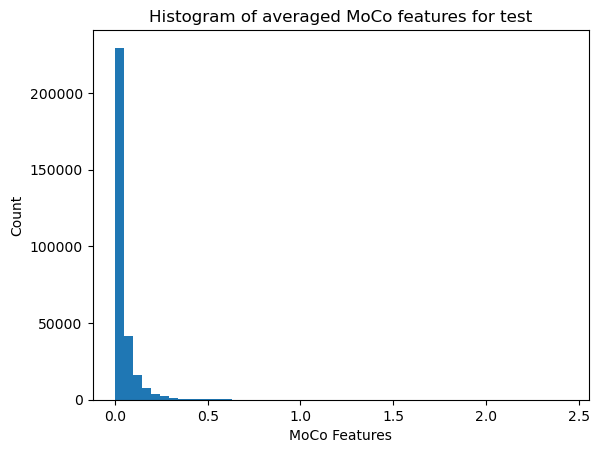

In [49]:
plt.hist(X_test.flatten(), bins=50)
plt.xlabel("MoCo Features")
plt.ylabel("Count")
plt.title("Histogram of averaged MoCo features for test");

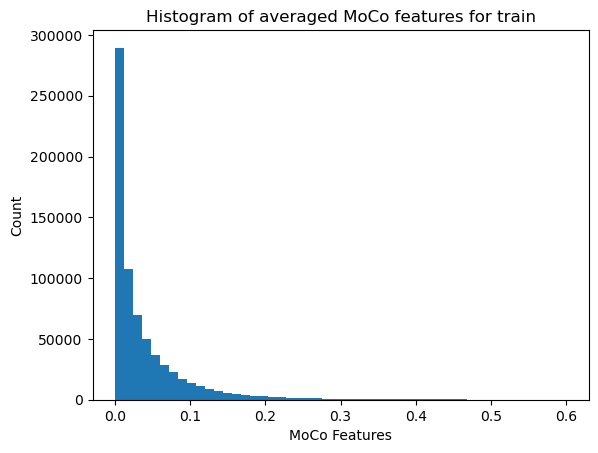

In [50]:
cond = np.where(X_train < 0.6)
plt.hist(X_train[cond].flatten(), bins=50)
plt.xlabel("MoCo Features")
plt.ylabel("Count")
plt.title("Histogram of averaged MoCo features for train");

## Analyse plain MoCo features

In [51]:
X_train, y_train, patients_train, samples_train, centers_train = load_mocov_train_data(
    data_path
)

In [52]:
X_test, patients_test, samples_test, centers_test = load_mocov_test_data(data_path)

In [53]:
np.sum(X_train[:, 1:].flatten() == 0) / (
    X_train[:, 1:].shape[0] * X_train[:, 1:].shape[1]
)

0.491675596725109

In [54]:
np.sum(X_test[:, 1:].flatten() == 0) / (X_test[:, 1:].shape[0] * X_test[:, 1:].shape[1])

0.5035306044200922

In [55]:
zoom_test = X_test[:, 0]
zoom_train = X_train[:, 0]

In [56]:
X_test = X_test[:, 1:]
X_train = X_train[:, 1:]

In [40]:
mut = X_train[y_train == 1].flatten()
no_mut = X_train[y_train == 0].flatten()

In [41]:
np.sum(mut == 0) / len(mut)

0.4919069023132324

In [42]:
np.sum(no_mut == 0) / len(no_mut)

0.4915385267469618

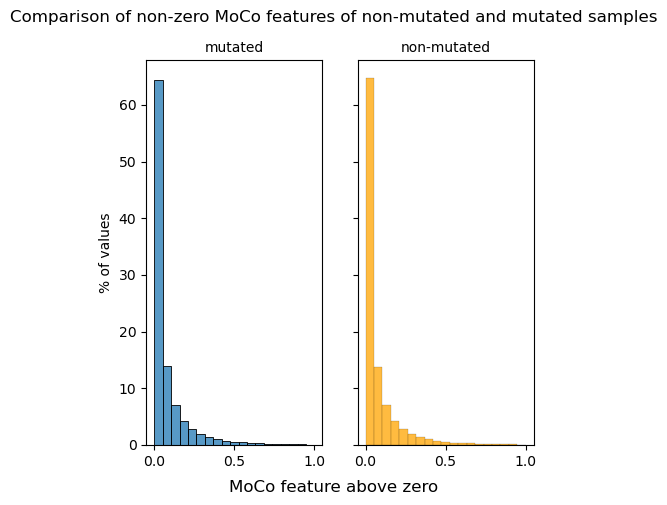

In [58]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(5, 5))
bins = np.linspace(0, 1.0, 20)
sns.histplot(ax=axs[0], x=mut[(mut > 0)], stat="percent", bins=bins)
sns.histplot(
    ax=axs[1],
    x=no_mut[(no_mut > 0)],
    stat="percent",
    bins=bins,
    color="orange",
    linewidth=0.1,
)
axs[0].set_title("mutated", size=10)
axs[1].set_title("non-mutated", size=10)
fig.suptitle("Comparison of non-zero MoCo features of non-mutated and mutated samples")
fig.supxlabel("MoCo feature above zero")
axs[0].set_ylabel("% of values");

In [55]:
print(np.percentile(X_train, 25))
print(np.percentile(X_train, 50))
print(np.percentile(X_train, 75))
print(np.percentile(X_train, 99))
print(np.max(X_train))

0.0
0.00021162723714951426
0.027307242155075073
0.5676655179262156
6.038034915924072


In [56]:
print(np.percentile(X_test, 25))
print(np.percentile(X_test, 50))
print(np.percentile(X_test, 75))
print(np.percentile(X_test, 99))
print(np.max(X_test))

0.0
0.0
0.025807907804846764
0.5690467357635498
5.853652477264404
